<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.06.Colab_Vegetation_Change_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

<a id="top"></a>
# Vegetation Change

This notebook uses global Landsat-8 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The selected data is used to calculate changes in the Normalized Difference Vegetation Index (NDVI) which is consistent with vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral index in each of those time periods. Significant changes in NDVI (vegetation greenness) are coincident with land change, as long as the comparisons are done between similar time periods (seasons or years). Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. It is expected that this algorithm can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas. In some cases the impacts may be negative (deforestation, mining, burning, drought) or positive (regrowth, improved soil moisture). 

It should also be noted that the selection of the baseline and analysis time period is critical. First, the two time periods should be similar (season, year) so that the vegetation state can be compared in similar growing conditions. Second, the time periods should be contain sufficiently clear (non-cloudy) data. If the baseline or analysis mosaic (composite of images) is contaminated with clouds, it will impact the results. Users should review the Cloud Statistics notebook to understand the cloud conditions for a given region and time period. 

This baseline notebook runs in about 5 minutes. The default region (0.1 degrees square) and time windows (one year each) uses about 10% of the allocated RAM memory. Selecting larger regions and time windows should be done carefully to avoid exceeding the system limits or having long run times. 

In [ ]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Vegetation_Change')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Spatial Extents of the Analysis [&#9652;](#top)</span>

In [6]:
# MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Obuasi, Ghana (mining region)
lat_long = (6.240, -1.905)
box_size_deg = 0.10

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [7]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define the Baseline and Analysis Time Periods [&#9652;](#top)</span>  

In [8]:
# MODIFY HERE

from datetime import datetime

# Select the start and end periods for your analysis (Year,Month,Day).
# These time windows will be used to make a median mosaic of the available scenes
# It is typical to pick a single date, season, or year 
# Be sure to evaluate the cloud conditions using the Cloud Statistics notebook

# Select the baseline time period (start and end)
baseline_time_period = ('2015-01-01', '2015-12-31')

# Select the analysis time period (start and end)
analysis_time_period = ('2020-01-01', '2020-12-31')

## <span id="load_data">Load the Data and Mask the Clouds [&#9652;](#top)</span>  

In [9]:
baseline_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'pixel_qa'],
                      time=baseline_time_period) 

In [10]:
analysis_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'pixel_qa'],
                      time=analysis_time_period) 

In [11]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask_baseline = landsat_qa_clean_mask(baseline_ds, platform=platform)
baseline_ds = baseline_ds.where(cloud_mask_baseline)

cloud_mask_analysis = landsat_qa_clean_mask(analysis_ds, platform=platform)
analysis_ds = analysis_ds.where(cloud_mask_analysis)

## Create a Median Mosaic for the Baseline and Analysis Time Periods

In [12]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
baseline_composite = create_median_mosaic(baseline_ds, cloud_mask_baseline)
analysis_composite = create_median_mosaic(analysis_ds, cloud_mask_analysis)

## <span id="anomalies">Calculate NDVI Anomaly Product [&#9652;](#top)</span>  

In [13]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [14]:
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)
NDVI_change = parameter_analysis_composite - parameter_baseline_composite

## Show the Analysis Results
The results will be shown using 4 images.<br>
(1) Baseline Composite (median mosaic of baseline time period)<br>
(2) Analysis Composite (median mosaic of analysis time period)<br>
(3) Vegetation Change (all changes shown at full scale)<br>
(4) Significant Vegetation Change (highlights largest changes)

In [15]:
from utils.data_cube_utilities.dc_rgb import rgb
from matplotlib.cm import RdYlGn, Greens, Reds
RdYlGn.set_bad('black',1.)

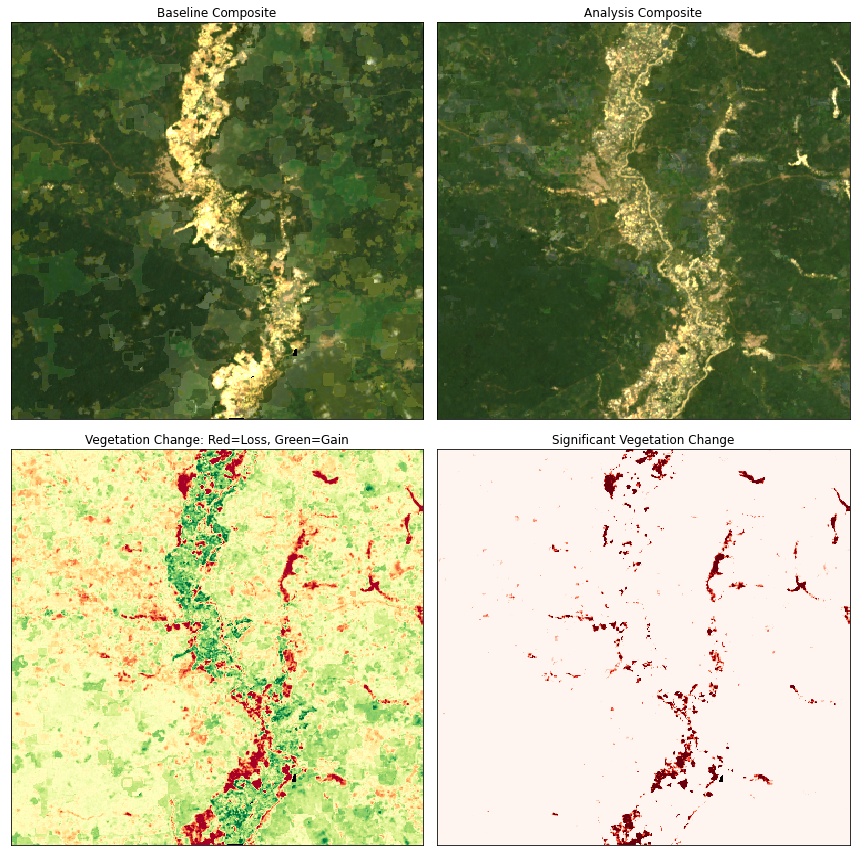

In [16]:
# MODIFY HERE

# Plotting Analysis Results
# There are several potential modifications in the code below
# Review the comments for more details about adjustable parameters

# Set the plotting configuration and figure size
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# Set black image borders
for sub_ax in ax.flatten():
    sub_ax.set_facecolor('black')

# Plot #1 = Baseline Composite (Median Mosaic) - RGB (upper left)
# VMIN and VMAX can be used to adjust image brightness
# Higher values of VMAX will darken the image
baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array()
baseline_rgb.plot.imshow(ax=ax[0,0], vmin=0, vmax=2000)

# Plot #2 = Analysis Composite (Median Mosaic) - RGB (upper right)
# VMIN and VMAX can be used to adjust image brightness
# Higher values of VMAX will darken the image
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array()
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=0, vmax=2000)

# Plot #3 = Vegetation Change based on NDVI (lower left)
# The full NDVI anomaly range is -1.0 to 1.0 (VMIN and VMAX)
# Using a smaller range (e.g. -0.4 to 0.4) will enhance the changes
# NDVI loss is seen in RED (NDVI_change < 0)
# NDVI gain is seen in GREEN (NDVI_change > 0)
# NOTE: Clouds will display in BLACK
NDVI_change.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

# Plot #4 = Significant Vegetation Change based on NDVI (lower right)
# SELECT one of the plots below ... LOSS or GAIN
# Adjust the range (VMIN to VMAX) to alter the results
# NOTE: Clouds will display in BLACK

# Significant vegetation LOSS is defined as "NDVI-Change" < -0.2 to -0.4
NDVI_change.plot(ax=ax[1,1], vmin=-0.4, vmax=-0.2, cmap = "Reds_r", add_colorbar=False)

# Significant vegetation GAIN is defined as "NDVI-Change" > 0.2 to 0.4
# NDVI_change.plot(ax=ax[1,1], vmin=0.2, vmax=0.4, cmap = "Greens", add_colorbar=False)

# Define titles and remove axis labels for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Change: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Significant Vegetation Change'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()